Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.


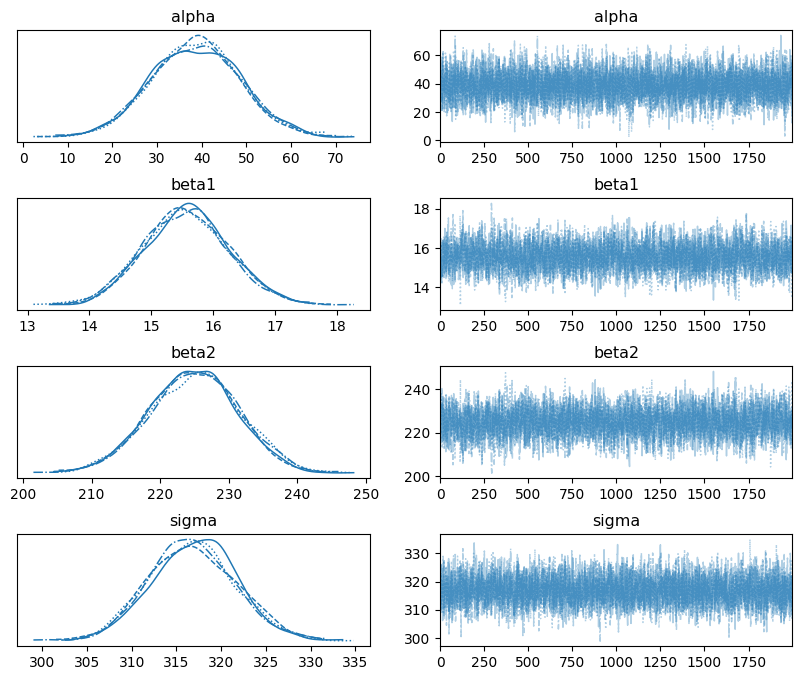

          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha   38.649  9.869    19.037     58.072      0.129    0.091    5846.0   
beta1   15.564  0.683    14.234     16.898      0.012    0.008    3285.0   
beta2  224.943  6.447   212.498    237.586      0.114    0.080    3220.0   
sigma  316.835  4.822   307.611    326.320      0.071    0.050    4586.0   

       ess_tail  r_hat  
alpha    4980.0    1.0  
beta1    3937.0    1.0  
beta2    4177.0    1.0  
sigma    5016.0    1.0  
95% HDI for beta1 (Processor Frequency): <xarray.Dataset> Size: 64B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    beta1    (hdi) float64 16B 14.23 16.9
95% HDI for beta2 (Log of Hard Drive Size): <xarray.Dataset> Size: 64B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    beta2    (hdi) float64 16B 212.5 237.6
Processor frequency significant: True
Log of hard drive size significant: True
9

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, beta3, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


95% HDI for beta3 (Premium): <xarray.Dataset> Size: 64B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    beta3    (hdi) float64 16B 1.782 39.1


In [19]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

data = pd.read_csv('Prices.csv')
data['LogHardDrive'] = np.log(data['HardDrive'])
data['PremiumBinary'] = data['Premium'].map({'yes': 1, 'no': 0})

price = data['Price'].values
speed = data['Speed'].values
log_hard_drive = data['LogHardDrive'].values
premium = data['PremiumBinary'].values

with pm.Model() as model:
    
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    beta2 = pm.Normal("beta2", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    mu = alpha + beta1 * speed + beta2 * log_hard_drive
    
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=price)
    
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

fig, axes = plt.subplots(len(trace.posterior.keys()), 2, figsize=(10, 8))
az.plot_trace(trace, axes=axes)

plt.subplots_adjust(hspace=0.5)
plt.show()

summary = az.summary(trace, hdi_prob=0.95)
print(summary)

beta1_hdi = az.hdi(trace.posterior['beta1'], hdi_prob=0.95)
beta2_hdi = az.hdi(trace.posterior['beta2'], hdi_prob=0.95)
print(f"95% HDI for beta1 (Processor Frequency): {beta1_hdi}")
print(f"95% HDI for beta2 (Log of Hard Drive Size): {beta2_hdi}")

lower_beta1 = beta1_hdi["beta1"].sel(hdi="lower").item()
higher_beta1 = beta1_hdi["beta1"].sel(hdi="higher").item()

lower_beta2 = beta2_hdi["beta2"].sel(hdi="lower").item()
higher_beta2 = beta2_hdi["beta2"].sel(hdi="higher").item()

significant_beta1 = lower_beta1 > 0 or higher_beta1 < 0
significant_beta2 = lower_beta2 > 0 or higher_beta2 < 0

print(f"Processor frequency significant: {significant_beta1}")
print(f"Log of hard drive size significant: {significant_beta2}")

config_speed = 33
config_log_hd = np.log(540)

with model:
    mu_posterior = trace.posterior['alpha'] + trace.posterior['beta1'] * config_speed + trace.posterior['beta2'] * config_log_hd

mu_simulated = np.random.choice(mu_posterior.values.flatten(), size=5000)

expected_price_hdi = az.hdi(mu_simulated, hdi_prob=0.9)
print(f"90% HDI for expected price: {expected_price_hdi}")

alpha_samples = trace.posterior['alpha'].values.flatten()
beta1_samples = trace.posterior['beta1'].values.flatten()
beta2_samples = trace.posterior['beta2'].values.flatten()
sigma_samples = trace.posterior['sigma'].values.flatten()

mu_posterior = alpha_samples + beta1_samples * config_speed + beta2_samples * config_log_hd

y_new_samples = np.random.normal(mu_posterior, sigma_samples)

y_new_hdi = az.hdi(y_new_samples, hdi_prob=0.90)

print(f"90% HDI for estimated price: {y_new_hdi}")

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    beta2 = pm.Normal("beta2", mu=0, sigma=10)
    beta3 = pm.Normal("beta3", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    mu = alpha + beta1 * speed + beta2 * log_hard_drive + beta3 * premium
    
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=price)
    
    trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

beta3_hdi = az.hdi(trace.posterior['beta3'], hdi_prob=0.95)

print(f"95% HDI for beta3 (Premium): {beta3_hdi}")





